# Beta learning models

Beta models are useful because they can be used to model a wide range of learning tasks where an outcome is binary and probabilistic (e.g., reward/no reward). They represent the probability of the outcome as a beta distribution, updating this distribution based on observed outcomes.

This modelling approach is used in the following papers: [1](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007341), [2](https://www.nature.com/articles/s41467-020-17977-w)



In [271]:
from behavioural_modelling.learning.beta_models import beta_mean_var, multiply_beta_by_scalar, average_betas, sum_betas, leaky_beta_update
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import beta
from functools import partial
import jax
import jax.numpy as jnp
from numpy.typing import ArrayLike

## Basic beta distribution functions

This package provides a number of functions for working with beta distributions.

### Get the mean and variance of a beta distribution

The mean and variance of a beta distribution is calculated as follows:

$$\mu = \frac{\alpha}{\alpha + \beta}$$

$$\sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$$

where $\alpha$ and $\beta$ are the shape parameters of the beta distribution.

The `beta_mean_var()` function calculates the mean and variance of a beta distribution given the shape parameters $\alpha$ and $\beta$.

In [3]:
a = 1
b = 1

mean, var = beta_mean_var(np.array([[a, b]]))

print(f"Mean: {mean}")
print(f"Variance: {var}")

Mean: [0.5]
Variance: [0.08333334]


This can be applied to multiple sets of shape parameters at once by passing an array of shape `(n, 2)` to the `beta_mean_var()` function.


In [4]:
N_OPTIONS = 10

# Create an array of beta params
rng = np.random.default_rng(0)
beta_params = rng.uniform(1, 10, size=(N_OPTIONS, 2))

# Calculate mean and variance of each beta distribution
mean, var = beta_mean_var(beta_params)

print(mean)
print(var)

[0.66261494 0.5436965  0.474468   0.46057996 0.38493064 0.89061487
 0.8700188  0.74566895 0.5988767  0.43490762]
[0.02003061 0.07053018 0.01345338 0.0165353  0.01451772 0.00939683
 0.01026292 0.01701204 0.01535782 0.02586546]


### Multiplying a beta distribution by a scalar

Multiplying a beta distribution by a scalar $c$ results in a truncated beta distribution with shape parameters $\alpha$ and $c \beta$ and truncation parameter $z$. This is intuitive if we consider that the upper limit on any value drawn from the beta distribution multiplied by $c$ is $c$.

However, it can sometimes be useful to be able to approximate this as a beta distribution with the original shape parameters $\alpha$ and $\beta$ without truncation (for example, if we later want to sum two beta distributions together, it's not straightforward to sum two truncated distributions when they have different $z$ values).

The `multiply_beta_by_scalar()` function approximates the result of multiplying a beta distribution by a scalar $c$ as a beta distribution with the original shape parameters $\alpha$ and $\beta$ without truncation. This approximation results in a beta distribution with the correct mean and variance, but the skew/kurtosis of the distribution will be slightly different to the true distribution.

We can demonstrate this empirically via simulation. First, we'll generate a beta distribution with shape parameters $\alpha = 5$ and $\beta = 5$, which we'll multiply by scalar $c = 0.5$.


In [5]:
a, b = (5, 1)
c = 0.5

We can then run simulations where we multiply draws from the beta distribution by the scalar and plot the resulting distribution.

Mean = 0.4167975690880757, Variance = 0.0049450535578850485


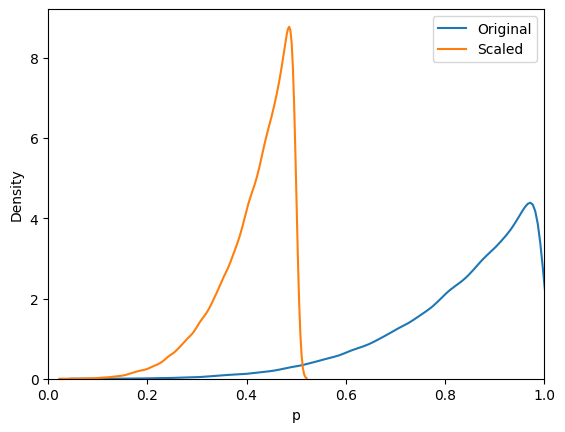

In [6]:
N_SIMS = 100000

original_ps = np.zeros(N_SIMS)
scaled_ps = np.zeros(N_SIMS)

for i in range(N_SIMS):
    original_ps[i] = np.random.beta(a, b)
    scaled_ps[i] = original_ps[i] * c

sns.kdeplot(original_ps, label='Original')
sns.kdeplot(scaled_ps, label='Scaled')
plt.xlim(0, 1)
plt.xlabel("p")

plt.legend()

print('Mean = {0}, Variance = {1}'.format(np.mean(scaled_ps), np.var(scaled_ps)))

If we use the `multiply_beta_by_scalar()` function to approximate the result of multiplying the beta distribution by the scalar, we can see that the mean and variance of the resulting distribution are the near enough the same as the true distribution, but the skew and kurtosis are slightly different.

Mean = 0.4166666567325592, Variance = 0.004960318095982075


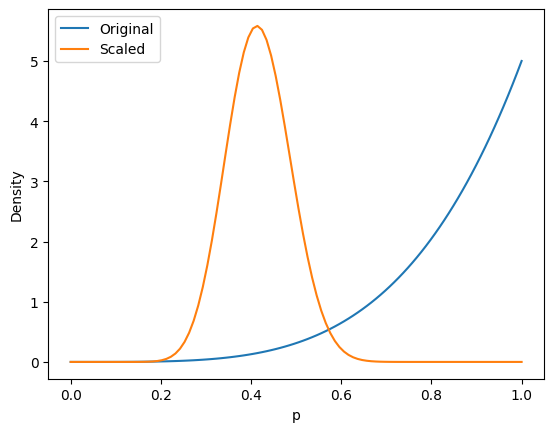

In [7]:
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, a, b), label='Original')

# Multiply beta distribution by scalar
scalar = 0.5
a_new, b_new = multiply_beta_by_scalar(np.array([[a, b]]), scalar)[0]
# plot
plt.plot(x, beta.pdf(x, a_new, b_new), label='Scaled')

plt.legend()

# Labels
plt.xlabel("p")
plt.ylabel("Density")

# get mean etc of new beta distribution using scipy beta
mean, var = beta.stats(a_new, b_new, moments="mv")
print('Mean = {0}, Variance = {1}'.format(mean, var))


### Summing beta distributions

We can sum two beta distributions together - essentially accumulating evidence about the probability of an event from two sources, each of which is represented by a beta distribution. This is useful for modelling learning tasks where we want to model the probability of an event (e.g., reward) based on multiple sources of evidence.

> **Note**: This only works if the means of the two beta distributions sum to <=1.

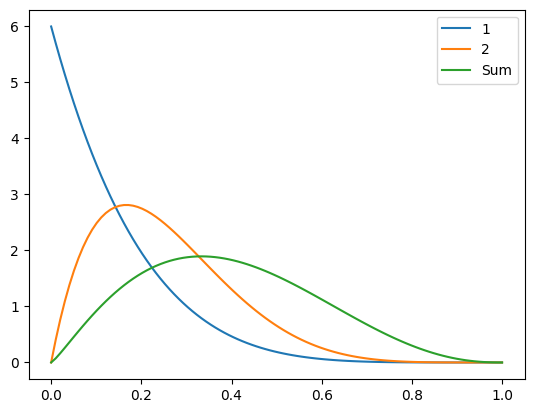

In [8]:
a1, b1 = (1, 6)
a2, b2 = (2, 6)

# plot
plt.plot(x, beta.pdf(x, a1, b1), label='1')
plt.plot(x, beta.pdf(x, a2, b2), label='2')

# Get average
sum_dist = sum_betas(np.array([[a1, b1]]), np.array([[a2, b2]]))

# plot
plt.plot(x, beta.pdf(x, sum_dist[0, 0], sum_dist[0, 1]), label='Sum')

plt.legend()

### Averaging beta distributions

We can also average together multiple beta distributions by simply taking the mean of the shape parameters of the beta distributions. We can also weight the beta distributions by scalar weights $w_1$ and $w_2$ to give more weight to one beta distribution than the other:

$$\alpha_{avg} = w_1 \alpha_1 + w_2 \alpha_2$$
$$\beta_{avg} = w_1 \beta_1 + w_2 \beta_2$$

We allow for separate weights rather than a single weight and its complement as this approach is used in some modelling formulations that combine multiple estimates (e.g., the MF/MB model in [Otto et al. (2013)](https://www.pnas.org/doi/full/10.1073/pnas.1312011110)).

This is implemented in the `average_betas()` function. If weights aren't specified, the beta distributions are weighted equally.


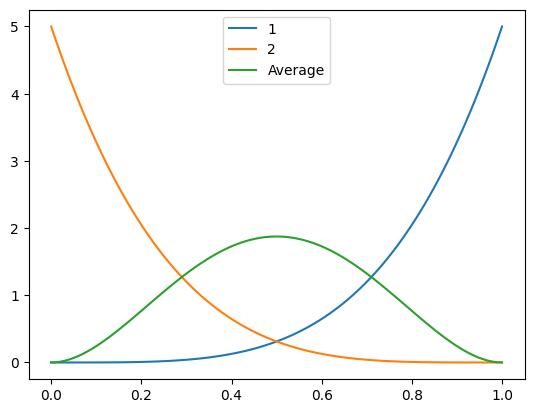

In [38]:
a1, b1 = (5, 1)
a2, b2 = (1, 5)

# plot
plt.plot(x, beta.pdf(x, a1, b1), label='1')
plt.plot(x, beta.pdf(x, a2, b2), label='2')

# Get average
avg = average_betas(np.array([[a1, b1]]), np.array([[a2, b2]]))

# plot
plt.plot(x, beta.pdf(x, avg[0, 0], avg[0, 1]), label='Average')

plt.legend()

If weights are used, the average is a weighted average:

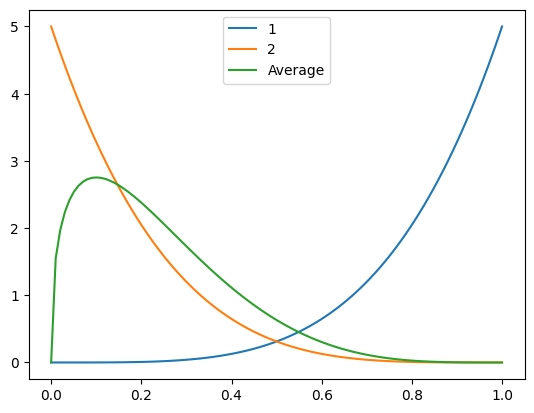

In [22]:
a1, b1 = (5, 1)
a2, b2 = (1, 5)

# plot
plt.plot(x, beta.pdf(x, a1, b1), label='1')
plt.plot(x, beta.pdf(x, a2, b2), label='2')

# Get average
avg = average_betas(np.array([[a1, b1]]), np.array([[a2, b2]]), W1=0.1, W2=0.9)

# plot
plt.plot(x, beta.pdf(x, avg[0, 0], avg[0, 1]), label='Average')

plt.legend()

## Asymmetric leaky beta learning model

This model is described in ([1](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007341), [2](https://www.nature.com/articles/s41467-020-17977-w)) and represents the probability of an outcome as a beta distribution which is updated on each trial.

Estimates are updated on each trial according to the following equations:

\begin{gathered}
A_i^{t+1}=\lambda \cdot A_i^{t}+outcome_t \cdot \tau^{+}  \\
B_i^{t+1}=\lambda \cdot B_i^{t}+(1-outcome_t) \cdot \tau^{-}
\end{gathered}

Where $\lambda$ is a decay parameter (lower values result in greater decay), $outcome_t$ is the outcome on trial $t$ (0 or 1), $\tau^{+}$ is the increment rate for positive outcomes, and $\tau^{-}$ is the increment rate for negative outcomes. Here $A_i$ and $B_i$ represent the shape parameters of the beta distribution for the $i$ th stimulus (note that these shape parameters are often referred to as $\alpha$ and $\beta$, but this terminology gets confusing as it means we have to describe e.g., the $\beta$ parameter of the $\beta$ distribution).

The update is implemented in the `leaky_beta_update()` function, which takes a set of beta distributions and updates them according to the above equations.

As an example, we can create three beta distributions representing the probability of reward for three options, and update them according to the above equations. We specify the distributions as an array of shape `(N_OPTIONS, 2)`, and as we have no prior knowledge we can initialise this as an array of ones.

In [174]:
# Create three beta distributions, initialised at (1, 1), of shape (3, 2)
beta_params = np.ones((3, 2))
print(beta_params)

[[1. 1.]
 [1. 1.]
 [1. 1.]]


On a given trial, the subject selects the 2nd option. We represent the choice as a one-hot encoded array of shape `(N_OPTIONS,)`.

In [173]:
choice = np.zeros(3)
choice[1] = 1
print(choice)

[0. 1. 0.]


The outcome on this trial is 1 (reward). The function assumes that a single outcome is received on each trial (i.e., we're not seeing different outcomes for each option). As we're modelling the probability of a given outcome, the outcome must be binary (0 or 1).

In [175]:
outcome = 1

We need to also choose some parameters for the model. We'll use $\lambda = 0.9$, $\tau^{+} = 0.5$, and $\tau^{-} = 0.1$. This means that there will be little decay, and that positive outcomes will result in a large increase in the probability of reward, whereas negative outcomes will result in a small decrease in the probability of reward.

In [182]:
lambda_ = 0.9  # can't use plain lambda as it's a reserved keyword in python
tau_p = 0.5
tau_n = 0.1

We can now use the update function to update our beta distributions.

In [179]:
leaky_beta_update(
    beta_params,
    choice,
    outcome,
    tau_p,
    tau_n,
    lambda_,
)

DeviceArray([[1. , 1. ],
             [1.5, 1. ],
             [1. , 1. ]], dtype=float32)

Note that no decay has been applied, as the function does not allow the shape parameters to go below 1. While beta distributions can have shape parameters below 1, these values can produce strange distributions (e.g., with joint peaks at 0 and 1) so for simplicity we don't allow this. If we set our starting shape parameters to a higher value, we can see that the decay is applied.

In [183]:
beta_params = np.ones((3, 2)) * 2

leaky_beta_update(
    beta_params,
    choice,
    outcome,
    tau_p,
    tau_n,
    lambda_,
)

DeviceArray([[1.9, 1.9],
             [2.4, 1.9],
             [1.9, 1.9]], dtype=float32)

If we loop over a set of trials we can see how the probability of reward for each option changes over time.

Here, we'll simulate 200 trials where the subject chooses randomly, and the option are rewarded at 0%, 50%, and 100% respectively.

In [285]:
N_TRIALS = 200

rng = np.random.default_rng(0)

# Generate outcomes for every trial
outcomes = np.zeros((N_TRIALS, 3))
outcomes[rng.choice(N_TRIALS, size=50, replace=False), 1] = 1
outcomes[:, 2] = 1

# Generate choices for every trial
choices = np.zeros((N_TRIALS, 3))
choices[range(N_TRIALS), rng.integers(0, 3, N_TRIALS)] = 1

# Starting beta params
beta_params = np.ones((N_TRIALS, 3, 2))

for i in range(N_TRIALS - 1):

    beta_params[i + 1, ...] = leaky_beta_update(
        beta_params[i, ...],
        choices[i, ...],
        outcomes[i, ...],
        tau_p,
        tau_n,
        lambda_,
    )

We can then get the mean and variance of these distributions to show how the probability of reward changes over time.

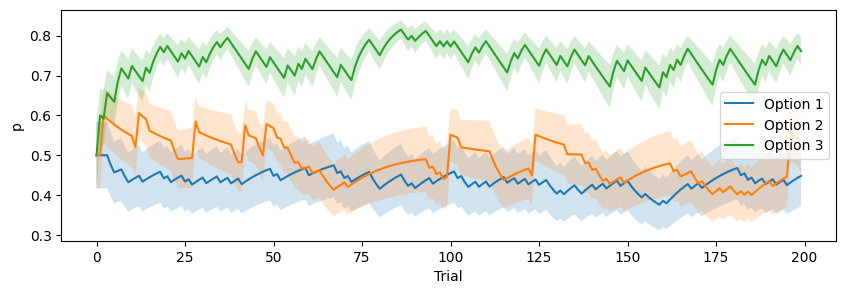

In [273]:
mean, var = beta_mean_var(beta_params)

plt.figure(figsize=(10, 3))

# Plot mean and variance of each option as line with shaded region
plt.plot(mean[:, 0], label='Option 1')
plt.fill_between(np.arange(N_TRIALS), mean[:, 0] - var[:, 0], mean[:, 0] + var[:, 0], alpha=0.2)

plt.plot(mean[:, 1], label='Option 2')
plt.fill_between(np.arange(N_TRIALS), mean[:, 1] - var[:, 1], mean[:, 1] + var[:, 1], alpha=0.2)

plt.plot(mean[:, 2], label='Option 3')
plt.fill_between(np.arange(N_TRIALS), mean[:, 2] - var[:, 2], mean[:, 2] + var[:, 2], alpha=0.2)

plt.xlabel("Trial")
plt.ylabel("p")

plt.legend()

All of these functions are designed to work with [JAX](https://jax.readthedocs.io) as it can speed things up. Most importanly, we can use it with `vmap` to vectorise the function across subjects/task blocks, making this much faster (and possible to run on GPUs).This also means that they can be used within [NumPyro](http://pyro.ai/numpyro/) for MCMC sampling.

Rather than running the update function using a Python loop, we can use `jax.lax.scan` to create a compiled function that runs the update function over a set of trials.

First, we need to define a wrapper function for the update function. This is because `jax.lax.scan` requires a function that takes only two arguments (one that is updated on each trial, and one that provides values to be used by the function on each trial), so we need to wrap the update function to take a tuple of arguments representing the outcomes and choices.

In [264]:
def leaky_beta_update_wrapper(
    beta_params: ArrayLike,
    choice_outcomes: ArrayLike,
    tau_p: float,
    tau_n: float,
    decay: float
) -> jnp.ndarray:

    # Unpack choices and _outcomes
    choice, outcome = choice_outcomes

    # Update
    beta_params_updated = leaky_beta_update(
        beta_params,
        choice,
        outcome,
        tau_p,
        tau_n,
        decay,
    )

    # Return updated params, both for the next iteration
    # and to keep track of values on each iteration
    return beta_params_updated, beta_params_updated

Because the parameters are fixed across trials, we can bake them into the function using `functools.partial`.

In [274]:
# Use partial to store the fixed parameters
leaky_beta_update_partial = partial(
    leaky_beta_update_wrapper,
    tau_p=tau_p,
    tau_n=tau_n,
    decay=lambda_,
)

We can then run the function using `jax.lax.scan` to update the beta distributions over a set of trials.

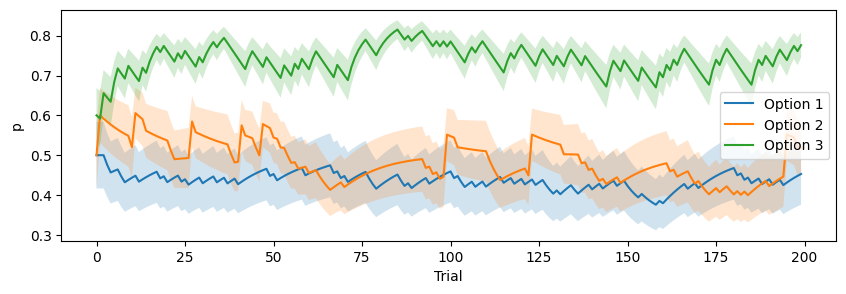

In [275]:
# Starting beta params
beta_params = np.ones((3, 2))

# Run the update
_, beta_params_updated = jax.lax.scan(
    leaky_beta_update_partial,
    beta_params,
    (choices, outcomes)
)

mean, var = beta_mean_var(beta_params_updated)

plt.figure(figsize=(10, 3))

# Plot mean and variance of each option as line with shaded region
plt.plot(mean[:, 0], label='Option 1')
plt.fill_between(np.arange(N_TRIALS), mean[:, 0] - var[:, 0], mean[:, 0] + var[:, 0], alpha=0.2)

plt.plot(mean[:, 1], label='Option 2')
plt.fill_between(np.arange(N_TRIALS), mean[:, 1] - var[:, 1], mean[:, 1] + var[:, 1], alpha=0.2)

plt.plot(mean[:, 2], label='Option 3')
plt.fill_between(np.arange(N_TRIALS), mean[:, 2] - var[:, 2], mean[:, 2] + var[:, 2], alpha=0.2)

plt.xlabel("Trial")
plt.ylabel("p")

plt.legend()

We can also use JAX's `vmap` function to vectorise the function across subjects, allowing us to run the function on multiple subjects efficiently without needing to explicitly defined the function in a vectorised manner.

In [352]:
def leaky_beta_update_vmap_function(
    beta_params: ArrayLike,
    choices: ArrayLike,
    outcomes: ArrayLike,
    tau_p: float, 
    tau_n: float, 
    decay: float
):
    
    # Pack choices and outcomes into a tuple
    choice_outcomes = (choices, outcomes)

    # Use partial to store the fixed parameters
    leaky_beta_update_partial = partial(
        leaky_beta_update_wrapper,
        tau_p=tau_p,
        tau_n=tau_n,
        decay=decay,
    )

    # Run the update
    _, beta_params_updated = jax.lax.scan(
        leaky_beta_update_partial,
        beta_params,
        (choices, outcomes)
    )

    return beta_params_updated

# Model parameter values for each subject
N_SUBJECTS = 50
tau_p = rng.uniform(0.1, 1, N_SUBJECTS)
tau_n = rng.uniform(0.1, 1, N_SUBJECTS)
lambda_ = rng.uniform(0.1, 1, N_SUBJECTS)

# Use vmap to vectorise over subjects
beta_params_vmap = jax.vmap(
    leaky_beta_update_vmap_function,
    in_axes=(None, None, None, 0, 0, 0)
)

beta_params_updated = beta_params_vmap(
    beta_params,
    choices,
    outcomes,
    tau_p,
    tau_n,
    lambda_,
)

print(beta_params_updated.shape)


(50, 200, 3, 2)
